In [1]:
from traitlets.config.manager import BaseJSONConfigManager
cm = BaseJSONConfigManager()
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
            'scroll': True
})

{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'scroll': True}

# Lecture 1: Floating-point arithmetic, vector norms

## Syllabus
**Week 1:** floating point, vector norms, matrix multiplication


## Today 
- Fixed vs. floating point arithmetic
- Concept of **backward** and **forward** stability of algorithms
- How to measure accuracy: vector norms

## Representation of numbers

Real numbers represent quantities: probabilities, velocities, masses, ...

It is important to know, how they are represented in the computer, which only knows about bits.

## Fixed point

- The most straightforward format for the representation of real numbers is **fixed point** representation, also known as **Qm.n** format.

- A **Qm.n** number is in the range $[-(2^m), 2^m - 2^{-n}]$, with resolution $2^{-n}$.

- Total storage is $m + n + 1$ bits.

- The range of numbers represented is fixed.

## Floating point
The numbers in computer memory are typically represented as **floating point numbers** 

A floating point number is represented as  

$$\textrm{number} = \textrm{significand} \times \textrm{base}^{\textrm{exponent}},$$

where *significand* is integer, *base* is positive integer  and *exponent* is integer (can be negative), i.e.

$$ 1.2 = 12 \cdot 10^{-1}.$$

## Fixed vs Floating

**Q**: What are the advantages/disadvantages of the fixed and floating points?

**A**:  In most cases, they work just fine.

- However, fixed point represents numbers within specified range and controls **absolute** accuracy.

- Floating point represent numbers with **relative** accuracy, and is suitable for the case when numbers in the computations have varying scale (i.e., $10^{-1}$ and $10^{5}$).

- In practice, if speed is of no concern, use float32 or float64.

## IEEE 754
In modern computers, the floating point representation is controlled by [IEEE 754 standard](https://en.wikipedia.org/wiki/IEEE_floating_point) which was published in **1985** and before that point different computers behaved differently with floating point numbers. 

IEEE 754 has:
- Floating point representation (as described above), $(-1)^s \times c \times b^q$.
- Two infinities, $+\infty$ and $-\infty$
- Two kinds of **NaN**: a quiet NaN (**qNaN**) and signalling NaN (**sNaN**) 
    - qNaN does not throw exception in the level of floating point unit (FPU), until you check the result of computations
    - sNaN value throws exception from FPU if you use corresponding variable. This type of NaN can be useful for initialization purposes
    - C++11 proposes [standard interface](https://en.cppreference.com/w/cpp/numeric/math/nan) for creating different NaNs 
- Rules for **rounding**
- Rules for $\frac{0}{0}, \frac{1}{-0}, \ldots$

Possible values are defined with
- base $b$
- accuracy $p$ - number of digits
- maximum possible value $e_{\max}$

and have the following restrictions 
- $ 0 \leq c \leq b^p - 1$
- $1 - e_{\max} \leq q + p - 1 \leq e_{\max}$ 

## The two most common format, single & double

The two most common formats, called **binary32** and **binary64** (called also **single** and **double** formats).

| Name | Common Name | Base | Digits | Emin | Emax |
|------|----------|----------|-------|------|------|
|binary32| single precision | 2 | 11 | -14 | + 15 |  
|binary64| double precision | 2 | 24 | -126 | + 127 |  



## Accuracy and memory
The **relative accuracy** of single precision is $10^{-7}-10^{-8}$,  

while for double precision is $10^{-14}-10^{-16}$.

<font color='red'> Crucial note 1: </font> A **float32** takes **4 bytes**, **float64**, or double precision, takes **8 bytes.**

<font color='red'> Crucial note 2: </font> These are the only two floating point-types supported in hardware.

<font color='red'> Crucial note 3: </font> You should use **double precision** in CSE and **float** on GPU/Data Science.


### Division accuracy demo

In [2]:
import numpy as np
import random
#c = random.random()
#print(c)
c = np.float32(0.925924589693)
print(c)
a = np.float32(8.9)
b = np.float32(c / a)
print('{0:10.16f}'.format(b))
print(a * b - c)

0.9259246
0.1040364727377892
-5.9604645e-08


### Square root accuracy demo

In [3]:
#a = np.array(1.585858585887575775757575e-5, dtype=np.float)
a = np.float32(5.0)
b = np.sqrt(a)
print('{0:10.16f}'.format(b ** 2 - a))

0.0000001468220603


### Exponent accuracy demo

In [4]:
a = np.array(2.28827272710, dtype=np.float32)
b = np.exp(a)
print(np.log(b) - a)

0.0


## Summary of demos

- For some values the inverse functions give exact answers
- The relative accuracy should be preserved due to the IEEE standard
- Does not hold for many modern GPU
- More details about adoptation of IEEE 754 standard for GPU you can find [here](https://docs.nvidia.com/cuda/floating-point/index.html#considerations-for-heterogeneous-world) 

## Loss of significance

- Many operations lead to the loss of digits [loss of significance](https://en.wikipedia.org/wiki/Loss_of_significance)
- For example, it is a bad idea to subtract two big numbers that are close, the difference will have fewer correct digits
- This is related to algorithms and their properties (forward/backward stability), which we will discuss later

## Summation algorithm

However, the rounding errors can depend on the algorithm.

- Consider the simplest problem: given $n$ floating point numbers $x_1, \ldots, x_n$  

- Compute their sum

$$S = \sum_{i=1}^n x_i = x_1 + \ldots + x_n.$$

- The simplest algorithm is to add one-by-one 

- What is the actual error for such algorithm? 

## Na&iuml;ve algorithm

Na&iuml;ve algorithm adds numbers one-by-one: 

$$y_1 = x_1, \quad y_2 = y_1 + x_2, \quad y_3 = y_2 + x_3, \ldots.$$

- The **worst-case** error is then proportional to $\mathcal{O}(n)$, while **mean-squared** error is $\mathcal{O}(\sqrt{n})$.

- The **Kahan algorithm** gives the worst-case error bound $\mathcal{O}(1)$ (i.e., independent of $n$).  

- <font color='red'> Can you find the $\mathcal{O}(\log n)$ algorithm? </font>

## Kahan summation
The following algorithm gives $2 \varepsilon + \mathcal{O}(n \varepsilon^2)$ error, where $\varepsilon$ is the machine precision.
```python
s = 0
c = 0
for i in range(len(x)):
    y = x[i] - c
    t = s + y
    c = (t - s) - y
    s = t
```

In [5]:
import math
from numba import jit

n = 10 ** 8
sm = 1e-10
x = np.ones(n, dtype=np.float32) * sm
x[0] = 1.0
true_sum = 1.0 + (n - 1)*sm
approx_sum = np.sum(x)
math_fsum = math.fsum(x)


@jit(nopython=True)
def dumb_sum(x):
    s = np.float32(0.0)
    for i in range(len(x)):
        s = s + x[i]
    return s

@jit(nopython=True)
def kahan_sum(x):
    s = np.float32(0.0)
    c = np.float32(0.0)
    for i in range(len(x)):
        y = x[i] - c
        t = s + y
        c = (t - s) - y
        s = t
    return s
k_sum = kahan_sum(x)
d_sum = dumb_sum(x)
print('Error in np sum: {0:3.1e}'.format(approx_sum - true_sum))
print('Error in Kahan sum: {0:3.1e}'.format(k_sum - true_sum))
print('Error in dumb sum: {0:3.1e}'.format(d_sum - true_sum))
print('Error in math fsum: {0:3.1e}'.format(math_fsum - true_sum))

Error in np sum: 1.9e-04
Error in Kahan sum: -1.3e-07
Error in dumb sum: -1.0e-02
Error in math fsum: 1.3e-10


## More complicated example

In [6]:
import numpy as np
test_list = [1, 1e20, 1, -1e20]
print(math.fsum(test_list))
print(np.sum(test_list))
print(1 + 1e20 + 1 - 1e20)

2.0
0.0
0.0


## Summary of floating-point 
You should be really careful with floating point, since it may give you incorrect answers due to rounding-off errors.

For many standard algorithms, the stability is well-understood and problems can be easily detected.

## Vectors
- In NLA we typically work not with **numbers**, but with **vectors**
- Recall that a vector in a fixed basis of size $n$ can be represented as a 1D array with $n$ numbers 
- Typically, it is considered as an $n \times 1$ matrix (**column vector**)

**Example:** 
Polynomials with degree $\leq n$ form a linear space. 
Polynomial $ x^3 - 2x^2 + 1$ can be considered as a vector $\begin{bmatrix}1 \\ -2 \\ 0 \\ 1\end{bmatrix}$ in the basis $\{x^3, x^2, x, 1\}$

## Vector norm

- Vectors typically provide an (approximate) description of a physical (or some other) object 

- One of the main question is **how accurate** the approximation is (1%, 10%)

- What is an acceptable representation, of course, depends on the particular applications. For example:
    - In partial differential equations accuracies $10^{-5} - 10^{-10}$ are the typical case
    - In data-based applications sometimes an error of $80\%$ is ok, since the interesting signal is corrupted by a huge noise

## Distances and norms

- Norm is a **qualitative measure of smallness of a vector** and is typically denoted as $\Vert x \Vert$.

The norm should satisfy certain properties:

- $\Vert \alpha x \Vert = |\alpha| \Vert x \Vert$
- $\Vert x + y \Vert \leq \Vert x \Vert + \Vert y \Vert$ (triangle inequality)
- If $\Vert x \Vert = 0$ then $x = 0$

The distance between two vectors is then defined as

$$
   d(x, y) = \Vert x - y \Vert.
$$

## Standard norms
The most well-known and widely used norm is **euclidean norm**:

$$\Vert x \Vert_2 = \sqrt{\sum_{i=1}^n |x_i|^2},$$

which corresponds to the distance in our real life. If the vectors have complex elements, we use their modulus.

## $p$-norm
Euclidean norm, or $2$-norm, is a subclass of an important class of $p$-norms:

$$
 \Vert x \Vert_p = \Big(\sum_{i=1}^n |x_i|^p\Big)^{1/p}.
$$

There are two very important special cases:
- Infinity norm, or Chebyshev norm is defined as the maximal element: 

$$
\Vert x \Vert_{\infty} = \max_i | x_i|
$$

<img src="pics/chebyshev.jpeg" style="height: 1%">

- $L_1$ norm (or **Manhattan distance**) which is defined as the sum of modules of the elements of $x$: 

$$
\Vert x \Vert_1 = \sum_i |x_i|
$$
  
<img src="pics/manhattan.jpeg" style="height">  


We will give examples where $L_1$ norm is very important: it all relates to the **compressed sensing** methods 
that emerged in the mid-00s as one of the most popular research topics.

## Equivalence of the norms
All norms are equivalent in the sense that

$$
   C_1 \Vert x \Vert_* \leq  \Vert x \Vert_{**} \leq C_2 \Vert x \Vert_*
$$  

for some positive constants $C_1(n), C_2(n)$, $x \in \mathbb{R}^n$ for any pairs of norms $\Vert \cdot \Vert_*$ and $\Vert \cdot \Vert_{**}$. The equivalence of the norms basically means that if the vector is small in one norm, it is small in another norm. However, the constants can be large.

## Computing norms in Python

The NumPy package has all you need for computing norms: ```np.linalg.norm``` function.


In [7]:
import numpy as np
n = 100
a = np.ones(n)
b = a + 1e-3 * np.random.randn(n)
print('Relative error in L1 norm:', np.linalg.norm(a - b, 1) / np.linalg.norm(b, 1))
print('Relative error in L2 norm:', np.linalg.norm(a - b) / np.linalg.norm(b))
print('Relative error in Chebyshev norm:', np.linalg.norm(a - b, np.inf) / np.linalg.norm(b, np.inf))

Relative error in L1 norm: 0.0007329368243860864
Relative error in L2 norm: 0.0009161454481284762
Relative error in Chebyshev norm: 0.0025611753793460725


## Unit disks in different norms

- A unit disk is a set of point such that $\Vert x \Vert \leq 1$
- For the euclidean norm a unit disk is a usual disk
- For other norms unit disks look very different

Text(0.5, 1.0, 'Unit disk in the p-th norm, $p=1$')

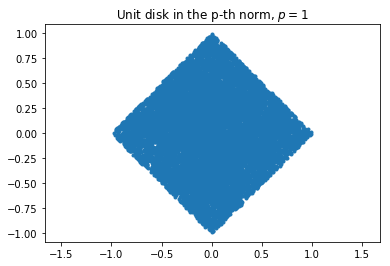

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
p = 1 # Which norm do we use
M = 40000 # Number of sampling points
a = np.random.randn(M, 2)
b = []
for i in range(M):
    if np.linalg.norm(a[i, :], p) <= 1:
        b.append(a[i, :])
b = np.array(b)
plt.plot(b[:, 0], b[:, 1], '.')
plt.axis('equal')
plt.title('Unit disk in the p-th norm, $p={0:}$'.format(p))

## Why $L_1$-norm can be important?

$L_1$ norm, as it was discovered quite recently, plays an important role in **compressed sensing**. 

The simplest formulation of the considered problem is as follows:

- You have some observations $f$ 
- You have a linear model $Ax = f$, where $A$ is an $n \times m$ matrix, $A$ is **known**
- The number of equations, $n$, is less than the number of unknowns, $m$

The question: can we find the solution?

The solution is obviously non-unique, so a natural approach is to find the solution that is minimal in the certain sense:

\begin{align*}
& \Vert x \Vert \rightarrow \min_x \\
\mbox{subject to } & Ax = f
\end{align*}

- Typical choice of $\Vert x \Vert = \Vert x \Vert_2$ leads to the **linear least squares problem** (and has been used for ages).  

- The choice $\Vert x \Vert = \Vert x \Vert_1$ leads to the [**compressed sensing**](https://en.wikipedia.org/wiki/Compressed_sensing)
- It typically yields the **sparsest solution**  

[A short demo](tv-denoising-demo.ipynb)

## What is a stable algorithm?

And we finalize the lecture by the concept of **stability**.

- Let $x$ be an object (for example, a vector) 
- Let $f(x)$ be the function (functional) you want to evaluate 

You also have a **numerical algorithm** ``alg(x)`` that actually computes **approximation** to $f(x)$.  

The algorithm is called **forward stable**, if $$\Vert alg(x) - f(x) \Vert  \leq \varepsilon $$  

The algorithm is called **backward stable**, if for any $x$ there is a close vector $x + \delta x$ such that

$$alg(x) = f(x + \delta x)$$

and $\Vert \delta x \Vert$ is small.

## Classical example
A classical example is the **solution of linear systems of equations** using Gaussian elimination which is similar to LU factorization (more details later)

We consider the **Hilbert matrix** with the elements

$$A = \{a_{ij}\}, \quad a_{ij} = \frac{1}{i + j + 1}, \quad i,j = 0, \ldots, n-1.$$

And consider a linear system

$$Ax = f.$$

We will look into matrices in more details in the next lecture, and for linear systems in the upcoming weeks

In [9]:
import numpy as np
n = 500
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)] # Hilbert matrix
A = np.array(a)
rhs =  np.random.random(n)
sol = np.linalg.solve(A, rhs)
print(np.linalg.norm(A.dot(sol) - rhs)/np.linalg.norm(rhs))
#plt.plot(sol)

34.458965526869264


In [10]:
rhs =  np.ones(n)
sol = np.linalg.solve(A, rhs)
print(np.linalg.norm(A.dot(sol) - rhs)/np.linalg.norm(rhs))
#plt.plot(sol)

1.8802880144962684e-07


## More examples of instability

How to compute the following functions in numerically stable manner?

- $\log(1 - \tanh^2(x))$
- $SoftMax(x)_j = \dfrac{e^{x_j}}{\sum\limits_{i=1}^n e^{x_i}}$  

In [11]:
u = 300
eps = 1e-6
print("Original function:", np.log(1 - np.tanh(u)**2))
eps_add = np.log(1 - np.tanh(u)**2 + eps)
print("Attempt imporove stability with add small constant:", eps_add)
print("Use more numerically stable form:", np.log(4) - 2 * np.log(np.exp(-u) + np.exp(u)))

Original function: -inf
Attempt imporove stability with add small constant: -13.815510557964274
Use more numerically stable form: -598.6137056388801


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
n = 5
x = np.random.randn(n)
x[0] = 1000
print(np.exp(x) / np.sum(np.exp(x)))
print(np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))))

[nan  0.  0.  0.  0.]
[1. 0. 0. 0. 0.]


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Take home message
- Floating point  (double, single, number of bytes), rounding error
- Norms are measures of smallness, used to compute the accuracy
- $1$, $p$ and Euclidean norms 
- $L_1$ is used in compressed sensing as a surrogate for sparsity (later lectures) 
- Forward/backward error (and stability of algorithms)  (later lectures)